In [94]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import utils

## Nominations and awards
We will analyse if the award receive or not have an influence on the difference between IMDB rating and metascore.

In [95]:
movies = pd.read_csv('data/processed/cmu_movies_augmented.csv')

one_hot_awards = pd.read_csv('data/processed/wikidata_awards_count.csv')

### Preparation of datas 

We need to begin to prepare data:
- Add the rating_difference column
- A column nomination and award is add to have a boolean value. The value of these columns are true is the movies as at least one nomination or award respectively.
- Remove the entries with no rating_difference
- Create the movies_award dataframe
    - adding one column by category award/nomination to count the number of award/nomination by category
    - adding a column awards_received with a list of all award/nomination received by movies
- Create a exploxed dataframe of movie_award in function of awards_receive

In [96]:
#we need to add the column rating_difference in movies 
movies['imdb_rating_scaled'] = movies['imdb_rating']*10
movies['rating_difference'] = movies['metascore'] - movies['imdb_rating_scaled']

#we add a column award and nomination. The column is true if the movie has at least one award or nomination
movies['nomination'] = np.where(movies['count_nomination'] > 0, True, False)
movies['award'] = np.where(movies['count_award'] > 0, True, False)

In [97]:
#check for NaN values in rating_difference
print("The number of NaN values on rating_difference: ",movies['rating_difference'].isna().sum())

#we drop the NaN values in rating_difference
movies = movies.dropna(subset=['rating_difference'])

The number of NaN values on rating_difference:  759


In [98]:
#We will use one_hot_award and movie to create a new dataframe movies_awards by joining both dataframes

columns_one_hot = one_hot_awards.columns.tolist()[1:]

#join movies and one_hot_awards
movies_awards = movies.join(one_hot_awards.set_index('freebase_id'), on='freebase_id')

#replace nan by 0 for columns_one_hot
movies_awards[columns_one_hot] = movies_awards[columns_one_hot].fillna(0)

#transform columns_one_hot name in lower case and replace space by _
columns_one_hot_ = []
for column in columns_one_hot:
    columns_one_hot_.append(column.lower().replace(' ', '_').replace("'", ""))

#change the name of columns in movies_awards
movies_awards.columns = movies_awards.columns.str.lower().str.replace(' ', '_').str.replace("'", "")

In [99]:
#For future analysis, we need an explode version of movies_awards
movies_awards['awards_received'] = movies_awards.apply(lambda row: list(row[columns_one_hot_][row[columns_one_hot_] > 0].index), axis=1)

movies_awards_explode = movies_awards.explode('awards_received')
movies_awards_explode['awards_received'] = movies_awards_explode['awards_received'].fillna("no_award")

### First stats on awards and nomination

We need to first have simple information of the quantity of nominations and awards received

In [133]:
movies_awards_explode_stat = movies_awards_explode.groupby('awards_received').agg({'wikipedia_id': ['count']}).reset_index()
movies_awards_explode_stat.columns = ['awards_received', 'count']
movies_awards_explode_stat = movies_awards_explode_stat.sort_values(by='count', ascending=False)

movies_awards_explode_stat['percentage'] = movies_awards_explode_stat['count']/len(movies_awards)*100

display(movies_awards_explode_stat)

8161
7770


,awards_received,count,percentage
11,no_award,6763,87.039897
13,oscar_nomination_count,414,5.328185
14,other_award_count,237,3.050193
15,other_nomination_count,136,1.750322
5,european_film_award_nomination_count,130,1.673102
12,oscar_award_count,127,1.634492
10,national_board_of_review_award_award_count,121,1.557272
4,european_film_award_award_count,38,0.489060
9,golden_raspberry_award_nomination_count,38,0.489060
7,golden_globe_nomination_count,30,0.386100


We see 87.04% of movies haven't received award or nomination and 12.96% have received at least a award or nomination. The total percentage is bigger than 100% because a movies can received more than one award. 

### Influence of award or nomination on the metascore and IMDb rating
First, we can have a quick look at the influence of awards on metascore and IMDB rating. 

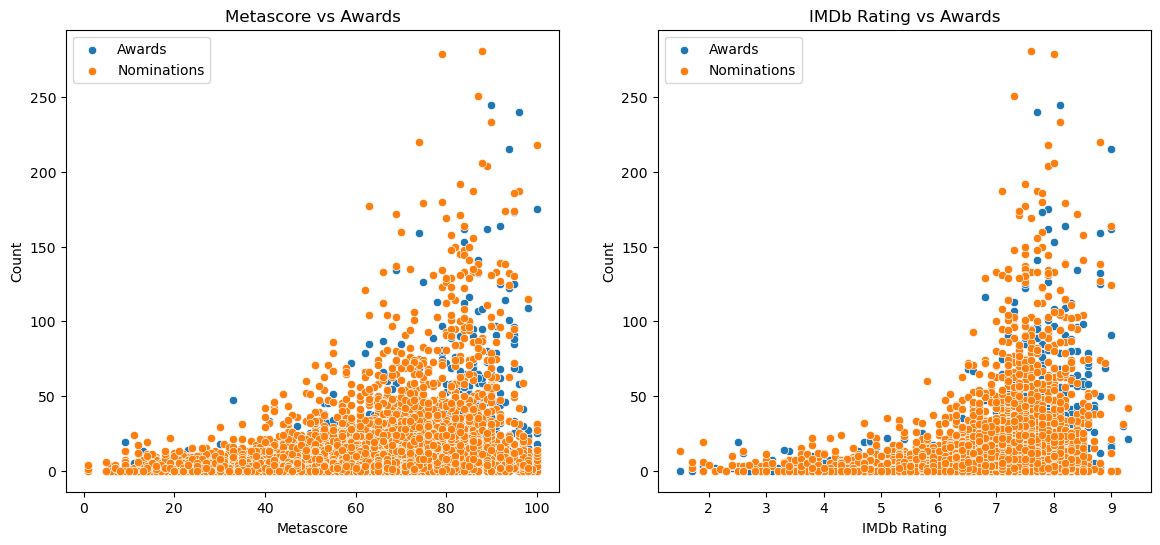

In [100]:
#We define a 2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot metascore vs nb awards in ax1
sns.scatterplot(x="metascore", y="count_award", data=movies, ax=ax1)
sns.scatterplot(x="metascore", y="count_nomination", data=movies, ax=ax1)
ax1.set_title("Metascore vs Awards")
ax1.set_ylabel("Count")
ax1.set_xlabel("Metascore")
ax1.legend(['Awards', 'Nominations'])


# Plot IMDb ratings vs nb awards in ax2
sns.scatterplot(x="imdb_rating", y="count_award", data=movies, ax=ax2)
sns.scatterplot(x="imdb_rating", y="count_nomination", data=movies, ax=ax2)
ax2.set_title("IMDb Rating vs Awards")
ax2.set_ylabel("Count")
ax2.set_xlabel("IMDb Rating")
ax2.legend(['Awards', 'Nominations'])

With the visual analysis, we see than the metascore and the IMDb rating is bigger when film have awards or awards nomination. We can confirm the trend with a linear regression. We check the impact on the 2 score when the movie has at least one nomination or one award:


In [101]:
#perform the linear regression
def linear_regression_helper(formula, df):
    # We use the ols function that allows us to specify a formula
    model = smf.ols(formula=formula, data=df)
    results = model.fit()
    print("The summary of the model for", formula, "is:")
    display(results.summary())
    return results

# Linear regression for metascore vs nomination
results = linear_regression_helper('metascore ~ nomination', movies)
# Linear regression for metascore vs award
results = linear_regression_helper('metascore ~ award', movies)
# Linear regression for imdb_rating vs nomination
results = linear_regression_helper('imdb_rating_scaled ~ nomination', movies)
# Linear regression for imdb_rating vs award
results = linear_regression_helper('imdb_rating_scaled ~ award', movies)

The summary of the model for metascore ~ nomination is:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              metascore   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     892.2
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          1.14e-185
Time:                        14:26:05   Log-Likelihood:                -33132.
No. Observations:                7770   AIC:                         6.627e+04
Df Residuals:                    7768   BIC:                         6.628e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             47.4607      0.393    120.900      0.000      46.691      48.230
nomination[T.True]    13.5147      0.452     29.869      0.000      12.628      14.402
==============================================================================
Omnibus:                       74.333   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.939
Skew:                          -0.222   Prob(JB):                     8.80e-17
Kurtosis:                       2.824   Cond. No.                         3.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The summary of the model for metascore ~ award is:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              metascore   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     1517.
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          2.44e-303
Time:                        14:26:05   Log-Likelihood:                -32861.
No. Observations:                7770   AIC:                         6.573e+04
Df Residuals:                    7768   BIC:                         6.574e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        47.3422      0.325    145.863      0.000      46.706      47.978
award[T.True]    15.5307      0.399     38.953      0.000      14.749      16.312
==============================================================================
Omnibus:                       84.968   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.788
Skew:                          -0.251   Prob(JB):                     1.43e-19
Kurtosis:                       2.877   Cond. No.                         3.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The summary of the model for imdb_rating_scaled ~ nomination is:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     imdb_rating_scaled   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     705.7
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          6.72e-149
Time:                        14:26:05   Log-Likelihood:                -28367.
No. Observations:                7770   AIC:                         5.674e+04
Df Residuals:                    7768   BIC:                         5.675e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             60.7725      0.213    285.818      0.000      60.356      61.189
nomination[T.True]     6.5101      0.245     26.564      0.000       6.030       6.990
==============================================================================
Omnibus:                      999.358   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1907.564
Skew:                          -0.823   Prob(JB):                         0.00
Kurtosis:                       4.783   Cond. No.                         3.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The summary of the model for imdb_rating_scaled ~ award is:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     imdb_rating_scaled   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     1263.
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          2.21e-256
Time:                        14:26:05   Log-Likelihood:                -28120.
No. Observations:                7770   AIC:                         5.624e+04
Df Residuals:                    7768   BIC:                         5.626e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        60.5727      0.176    343.519      0.000      60.227      60.918
award[T.True]     7.6967      0.217     35.533      0.000       7.272       8.121
==============================================================================
Omnibus:                     1128.782   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2395.764
Skew:                          -0.874   Prob(JB):                         0.00
Kurtosis:                       5.084   Cond. No.                         3.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see first that in each case the p-value is very low. Then we can focus on the coefficient of the variable on the score (metascore/imdb_rating_scaled) 
- metascore ~ nomination: 13.5147
- metascore ~ award: 15.5307
- imdb_rating_scaled ~ nomination: 6.5101	
- imdb_rating_scaled ~ award: 7.6967

We can notice:
- There is a positive correlation between score and award/nomination
- The correlation is bigger for metascore than for IMDB rating
- A film that wins an award as well as a nomination seem to have a bigger metascore and IMDB rating. 

### Influence of award/nomination on rating_difference
From previous analysis, the correlation seems bigger for metascore than IMDB rating, so an award/nomination should have an impact on the rating_difference. We can begin to look the IMDb rating in function of metascore for all film on a scatter plot.

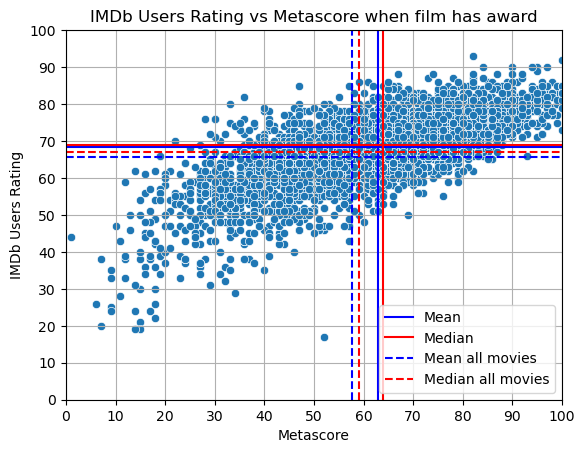

In [102]:
#scatter plot of metascore vs imdb_rating if award is true
movie_with_award = movies_awards[movies_awards['award'] == True]
sns.scatterplot(x="metascore", y="imdb_rating_scaled", data=movie_with_award)

# plot mean lines
plt.axhline(y=movie_with_award['imdb_rating_scaled'].mean(), color='b', linestyle='-')
plt.axvline(x=movie_with_award['metascore'].mean(), color='b', linestyle='-')

#plot mean line of all movies
plt.axhline(y=movies_awards['imdb_rating_scaled'].mean(), color='b', linestyle='--')
plt.axvline(x=movies_awards['metascore'].mean(), color='b', linestyle='--')

# plot median lines
plt.axhline(y=movie_with_award['imdb_rating_scaled'].median(), color='r', linestyle='-')
plt.axvline(x=movie_with_award['metascore'].median(), color='r', linestyle='-')

#plot median line of all movies
plt.axhline(y=movies_awards['imdb_rating_scaled'].median(), color='r', linestyle='--')
plt.axvline(x=movies_awards['metascore'].median(), color='r', linestyle='--')

# legend the lines but not the scatter plots
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
blue_line_ = mlines.Line2D([], [], color='blue', label='Mean all movies', linestyle='--')
red_line = mlines.Line2D([], [], color='red', label='Median')
red_line_ = mlines.Line2D([], [], color='red', label='Median all movies', linestyle='--')
plt.legend(handles=[blue_line, red_line, blue_line_, red_line_])

plt.title("IMDb Users Rating vs Metascore when film has award")
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, 101, 10))
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("Metascore")
plt.ylabel("IMDb Users Rating")
plt.grid()

In [103]:
#Perform OLS for the rating difference vs awards 

model = smf.ols(formula='rating_difference ~ award', data=movies)

results = model.fit()

print(results.summary())

df_results = pd.DataFrame(results.params)
df_results['p-value'] = results.pvalues
df_results['lower-ci'] = results.conf_int()[0]
df_results['upper-ci'] = results.conf_int()[1]

#drop line Intercept
df_results = df_results.drop('Intercept')

display(df_results)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     722.9
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          2.45e-152
Time:                        14:26:05   Log-Likelihood:                -30424.
No. Observations:                7770   AIC:                         6.085e+04
Df Residuals:                    7768   BIC:                         6.087e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -13.2304      0.237    -55.781

,0,p-value,lower-ci,upper-ci
award[T.True],7.834059,2.453387e-152,7.262903,8.405214


In [104]:
#Perform OLS for the rating difference vs nomination

model = smf.ols(formula='rating_difference ~ nomination', data=movies)

results = model.fit()

temp = pd.DataFrame(results.params)
temp['p-value'] = results.pvalues
temp['lower-ci'] = results.conf_int()[0]
temp['upper-ci'] = results.conf_int()[1]

#drop line Intercept
temp = temp.drop('Intercept')

#add temp to df_results
df_results = pd.concat([df_results, temp])

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     466.7
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          1.49e-100
Time:                        14:26:05   Log-Likelihood:                -30543.
No. Observations:                7770   AIC:                         6.109e+04
Df Residuals:                    7768   BIC:                         6.110e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -13.3118      0

In [105]:
#rename column 0 to coef
df_results = df_results.rename(columns={0: 'coef'})
display(df_results)


,coef,p-value,lower-ci,upper-ci
award[T.True],7.834059,2.453387e-152,7.262903,8.405214
nomination[T.True],7.004585,1.489961e-100,6.368962,7.640208


From the plot, the mean and median is bigger when the film has award/nomination compared to when the film doesn't win an award/nomination. The difference seem bigger for the metascore than for IMDb rating.

The coefficient result for the OLS are 
- rating_difference ~ nomination: 7.004585
- rating_difference ~ award: 7.834059	

in the two case the p-value is very low (<< 0.05)

From the plot and the 2 OLS, it's seems that having an award or a nomination reduce the difference between IMDb rating and metascore. The previous result isn't contradict.



### Influence of category of awards on rating_difference

We need to more focus on the type of awards receive by the movies to confirm this first analysis and check if the rating difference change with the type of award

In [106]:
#print the count the number of award by award_received by ascending order
print('Number of award by award_received')
print(movies_awards_explode['awards_received'].value_counts())

Number of award by award_received
awards_received
no_award                                                                   6763
oscar_nomination_count                                                      414
other_award_count                                                           231
other_nomination_count                                                      136
european_film_award_nomination_count                                        130
oscar_award_count                                                           127
national_board_of_review_award_award_count                                  121
european_film_award_award_count                                              38
golden_raspberry_award_nomination_count                                      38
golden_globe_nomination_count                                                30
cesar_award_count                                                            26
cesar_nomination_count                                                

From this first analysis, we can see some award with a small number of movies. We decide to move these nomination to other_award_count and other_nomination_count.

The second problem is in some cases we have more movies with award than with nomination. We think that for some category (like National Board of Review) the movie are remove from nomination when the movie has an award. 
We will focus only on the metric award_count to avoid analysis and interpretation problem with this problem. 

As seen before, with OLS on rating_difference in function of awards and nomination and on the first graphic analysis, the fact to have award increase a litle more the rating and the impact is bigger with movies than nomination but the trend is similar on the rating_difference.

In [107]:
# *award_count < 10: move to other_award_count

award_nomination_to_move = movies_awards_explode['awards_received'].value_counts()<10
#series to list
award_nomination_to_move = award_nomination_to_move.index[award_nomination_to_move.values].tolist()
print("The category to move to other_nomination_count and other_award_count: \n", award_nomination_to_move)

#if name end with award_count save in award_to_move
#if name and with nomination_count save in nomination_to_move
award_to_move = []
nomination_to_move = []
for award in award_nomination_to_move:
    if award.endswith('award_count'):
        award_to_move.append(award)
    elif award.endswith('nomination_count'):
        nomination_to_move.append(award)
print("The category to move to other_award_count:\n", award_to_move)    
print("The category to move to other_nomination_count: \n", nomination_to_move)

#move the award and nomination to other_award_count and other_nomination_count
movies_awards['other_award_count'] = movies_awards['other_award_count'] + movies_awards[award_to_move].sum(axis=1)
movies_awards['other_nomination_count'] = movies_awards['other_nomination_count'] + movies_awards[nomination_to_move].sum(axis=1)

#drop award_to_move and nomination_to_move
movies_awards = movies_awards.drop(award_to_move, axis=1)
movies_awards = movies_awards.drop(nomination_to_move, axis=1)

The category to move to other_nomination_count and other_award_count: 
 ['palme_dor_award_count', 'toronto_international_film_festival_award_award_count', 'venice_film_festival_award_award_count', 'filmfare_award_award_count', 'national_board_of_review_award_nomination_count', 'filmfare_award_nomination_count']
The category to move to other_award_count:
 ['palme_dor_award_count', 'toronto_international_film_festival_award_award_count', 'venice_film_festival_award_award_count', 'filmfare_award_award_count']
The category to move to other_nomination_count: 
 ['national_board_of_review_award_nomination_count', 'filmfare_award_nomination_count']


In [108]:
#We need to update column awards_received and update the explode version

#remove award_nomination_to_move from columns_one_hot_
columns_one_hot_ = list(set(columns_one_hot_) - set(award_to_move) - set(nomination_to_move))

movies_awards['awards_received'] = movies_awards.apply(lambda row: list(row[columns_one_hot_][row[columns_one_hot_] > 0].index), axis=1)

movies_awards_explode = movies_awards.explode('awards_received')
movies_awards_explode['awards_received'] = movies_awards_explode['awards_received'].fillna("no_award")

We check the result 

In [109]:
#print the count the number of award by award_received by ascending order
print('Number of award by award_received')
print(movies_awards_explode['awards_received'].value_counts())

Number of award by award_received
awards_received
no_award                                                                   6763
oscar_nomination_count                                                      414
other_award_count                                                           237
other_nomination_count                                                      136
european_film_award_nomination_count                                        130
oscar_award_count                                                           127
national_board_of_review_award_award_count                                  121
european_film_award_award_count                                              38
golden_raspberry_award_nomination_count                                      38
golden_globe_nomination_count                                                30
cesar_award_count                                                            26
cesar_nomination_count                                                

### Basic exploration
We will first have a quick look at the data with a scatter plot by category of award (in comparaison as no award) of IMDb rating in function of metascore.

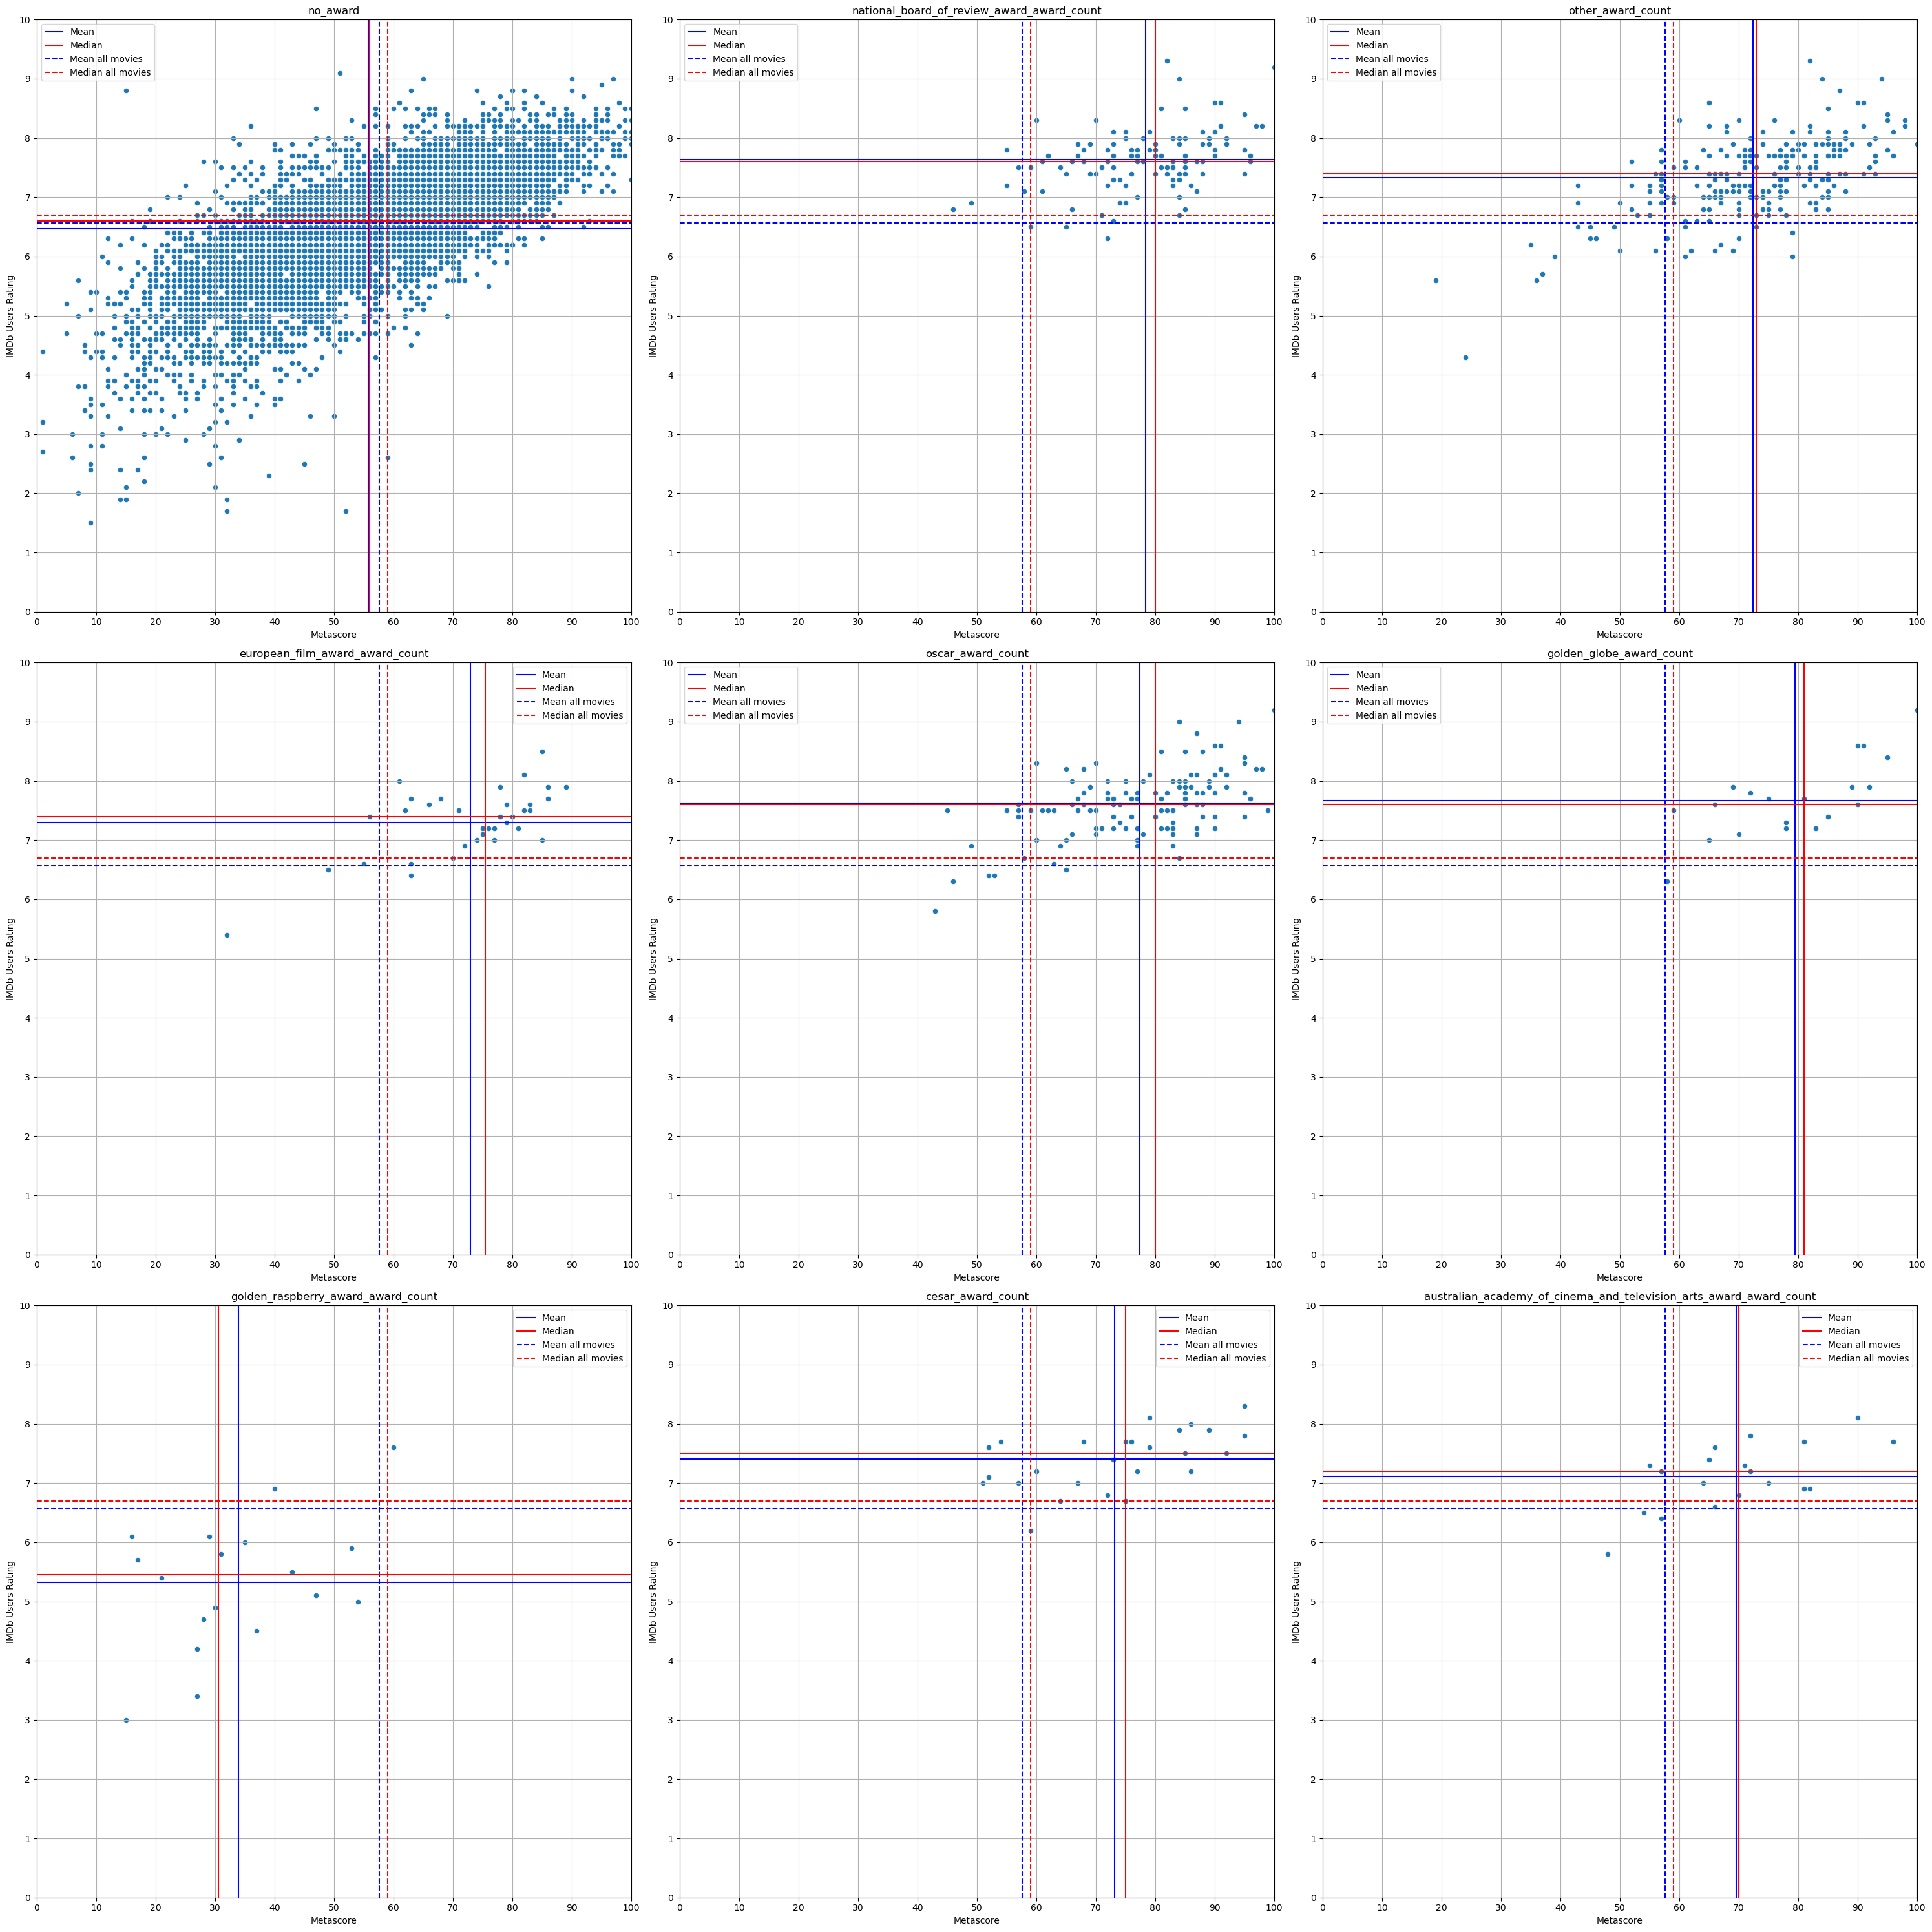

In [110]:
#plot scatter plot of metascore vs imdb_rating if film has award by award_received

fig, ax = plt.subplots(3, 3, figsize=(30, 30))

def plot_scatter(df, ax, award_received):
    df_plot = df[df['awards_received'] == award_received]

    sns.scatterplot(x="metascore", y="imdb_rating", data=df_plot, ax=ax)

    # plot mean lines
    ax.axhline(y=df_plot['imdb_rating'].mean(), color='b', linestyle='-')
    ax.axvline(x=df_plot['metascore'].mean(), color='b', linestyle='-')

    #plot mean line of all movies
    ax.axhline(y=movies_awards['imdb_rating'].mean(), color='b', linestyle='--')
    ax.axvline(x=movies_awards['metascore'].mean(), color='b', linestyle='--')

    # plot median lines
    ax.axhline(y=df_plot['imdb_rating'].median(), color='r', linestyle='-')
    ax.axvline(x=df_plot['metascore'].median(), color='r', linestyle='-')

    #plot median line of all movies
    ax.axhline(y=movies_awards['imdb_rating'].median(), color='r', linestyle='--')
    ax.axvline(x=movies_awards['metascore'].median(), color='r', linestyle='--')

    # legend the lines but not the scatter plots
    import matplotlib.lines as mlines
    blue_line = mlines.Line2D([], [], color='blue', label='Mean')
    blue_line_ = mlines.Line2D([], [], color='blue', label='Mean all movies', linestyle='--')
    red_line = mlines.Line2D([], [], color='red', label='Median')
    red_line_ = mlines.Line2D([], [], color='red', label='Median all movies', linestyle='--')
    ax.legend(handles=[blue_line, red_line, blue_line_, red_line_])

    #plot name
    ax.set_title(award_received)
    ax.set_xticks(range(0, 101, 10))
    ax.set_yticks(range(0, 11, 1))
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 10)
    ax.set_xlabel("Metascore")
    ax.set_ylabel("IMDb Users Rating")
    ax.grid()

i=0
for j, award_received in enumerate(movies_awards_explode['awards_received'].unique()):
    #keep only awards_received with name and with award_count and no_award
    if award_received == 'no_award' or award_received.endswith('award_count'):
        plot_scatter(movies_awards_explode, ax[i//3, i%3], award_received)
        i = i + 1

#rescale the figure
fig.tight_layout()

We can also plot the average rating difference by award to have a better vision on the the difference.

,awards_received,rating_difference,number_of_movies,ci_error
6,golden_globe_award_count,2.761905,21,1.901008
10,national_board_of_review_award_award_count,2.041322,121,0.926604
12,oscar_award_count,1.188976,127,0.955956
4,european_film_award_award_count,-0.052632,38,1.493917
2,cesar_award_count,-0.884615,26,2.330617
14,other_award_count,-0.919831,237,0.730383
0,australian_academy_of_cinema_and_television_ar...,-1.578947,19,2.312331
11,no_award,-8.912021,6763,0.153269
8,golden_raspberry_award_award_count,-19.333333,18,3.109126


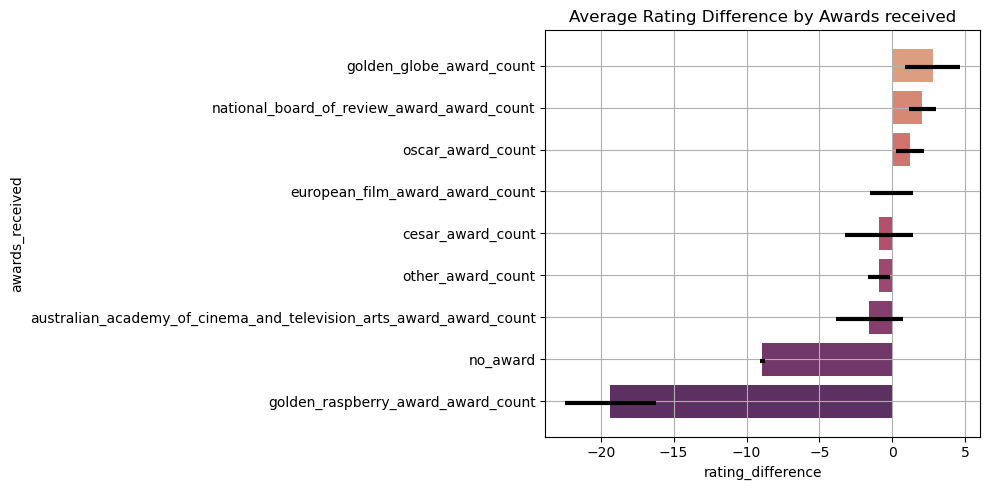

In [111]:
movies_awards_explode_groupby = movies_awards_explode.groupby('awards_received')['rating_difference'].agg(['mean', 'count', 'sem']).reset_index()
movies_awards_explode_groupby = movies_awards_explode_groupby.rename(columns={'mean': 'rating_difference', 'count': 'number_of_movies', 'sem': 'ci_error'})
movies_awards_explode_groupby = movies_awards_explode_groupby.sort_values(by='rating_difference', ascending=False)

#keep only awards_received with name end with award_count and name is no_award
award_to_keep = movies_awards_explode_groupby['awards_received'].str.endswith('award_count') | (movies_awards_explode_groupby['awards_received'] == 'no_award')

movies_awards_explode_groupby = movies_awards_explode_groupby[award_to_keep]
display(movies_awards_explode_groupby)

utils.plot_results(movies_awards_explode_groupby, 'awards_received', 'rating_difference', 'Average Rating Difference by Awards received')


With the first plot, we see an improve for all award in the mean and median metascore and IMDb rating except for the Golden Raspberry Award. The improve depend on the award, but it's more important for metascore than IMDb rating.

In this table and second plot, we see that for all award categroy, except for Golden Raspbery Award, the average rating difference is smaller than the average for all movies. 
The Golden Raspbery is a trolling aware because they awards for worst film and worst actor and not the quality of a movie. This explains why metascore and IMDB rating rate are lower.

We can now perform Pearson and OLS fit to look if the difference is significant.

### Pearson Correlation

Significant results: 8/8


,correlation,p_value,lower_ci,upper_ci,feature,col_id,Awards
onehot_national_board_of_review_award_award_count,0.095919,2.387351e-17,0.073841,0.117903,onehot_national_board_of_review_award_award_count,national_board_of_review_award_award_count,national_board_of_review_award_award_count
onehot_oscar_award_count,0.082627,2.993182e-13,0.060503,0.104671,onehot_oscar_award_count,oscar_award_count,oscar_award_count
onehot_other_award_count,0.058675,2.271111e-07,0.036487,0.080805,onehot_other_award_count,other_award_count,other_award_count
onehot_european_film_award_award_count,0.036703,1.212941e-03,0.014479,0.058890,onehot_european_film_award_award_count,european_film_award_award_count,european_film_award_award_count
onehot_golden_globe_award_count,0.028644,1.156999e-02,0.006412,0.050847,onehot_golden_globe_award_count,golden_globe_award_count,golden_globe_award_count
onehot_cesar_award_count,0.028004,1.356657e-02,0.005772,0.050208,onehot_cesar_award_count,cesar_award_count,cesar_award_count
onehot_australian_academy_of_cinema_and_television_arts_award_award_count,0.025497,2.460692e-02,0.003263,0.047706,onehot_australian_academy_of_cinema_and_televi...,australian_academy_of_cinema_and_television_ar...,australian_academy_of_cinema_and_television_ar...
onehot_golden_raspberry_award_award_count,-0.038555,6.757554e-04,-0.060738,-0.016333,onehot_golden_raspberry_award_award_count,golden_raspberry_award_award_count,golden_raspberry_award_award_count


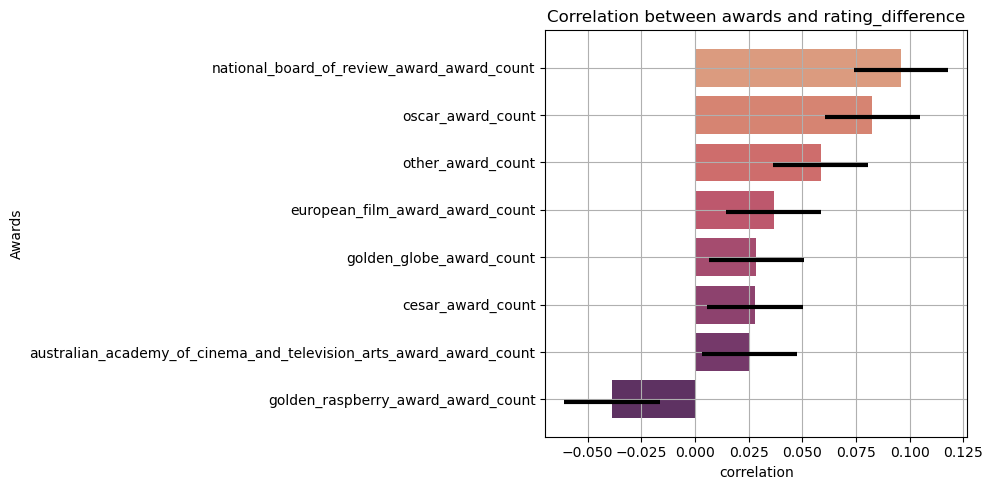

In [112]:
#column rename - add a prefix onehot_
movies_awards = movies_awards.rename(columns={column: 'onehot_'+column for column in columns_one_hot_})

#Pearson correlation coefficient
award_to_analyse = movies_awards.columns.str.endswith('award_count')
award_to_analyse = movies_awards.columns[award_to_analyse].tolist() 
award_pearsonr_results, award_pearsonr_significant  = utils.study_pearson(movies_awards, award_to_analyse, 'rating_difference', 
                                                                           colname='Awards', title="Correlation between awards and rating_difference")

The rating difference is for the eight awards categories significant. 

We can now compute the basic OLS

### Basic OLS

Dep. Variable:,rating_difference,R-squared:,0.014
Model:,OLS,Adj. R-squared:,0.013
Method:,Least Squares,F-statistic:,14.12
Date:,"Mon, 18 Dec 2023",Prob (F-statistic):,1.34e-20
Time:,14:26:08,Log-Likelihood:,-30713.
No. Observations:,7770,AIC:,6.144e+04
Df Residuals:,7761,BIC:,6.151e+04
Df Model:,8,,
Covariance Type:,nonrobust,,


Omnibus:,63.768,Durbin-Watson:,2.026
Prob(Omnibus):,0.000,Jarque-Bera (JB):,63.506
Skew:,-0.206,Prob(JB):,1.62e-14
Kurtosis:,2.840,Cond. No.,12.7




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.014348,0.013332,10.195661,158.819548
baseline,0.0,0.0,10.266286,161.131427
improvement,inf,inf,-0.69%,-1.43%


Significant results: 5/8


,feature,coef,p_value,lower_ci,upper_ci,col_id,Awards
2,onehot_national_board_of_review_award_award_count,5.4065,0.000,3.267,7.546,national_board_of_review_award_award_count,national_board_of_review_award_award_count
3,onehot_european_film_award_award_count,2.4932,0.039,0.131,4.855,european_film_award_award_count,european_film_award_award_count
0,onehot_oscar_award_count,1.4996,0.001,0.642,2.357,oscar_award_count,oscar_award_count
1,onehot_other_award_count,0.6386,0.009,0.161,1.116,other_award_count,other_award_count
4,onehot_golden_raspberry_award_award_count,-3.6097,0.001,-5.716,-1.504,golden_raspberry_award_award_count,golden_raspberry_award_award_count


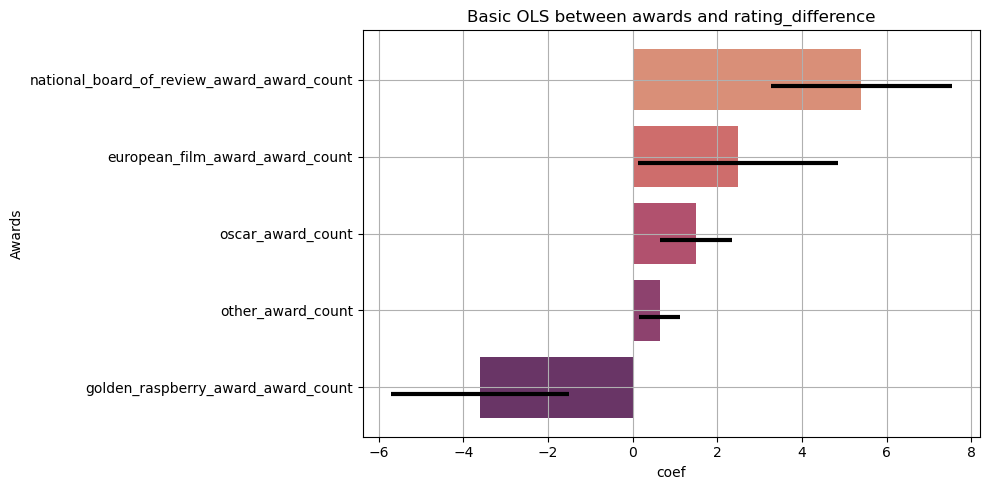

In [113]:
award_ols_results, award_ols_significant = utils.study_OLS(movies_awards, award_to_analyse, 'rating_difference',
                                                           colname='Awards', title="Basic OLS between awards and rating_difference")

### VIF (Variance Inflation Factor) Filtering

In [114]:
award_vif_significant = utils.filter_VIF(movies_awards, award_pearsonr_significant, threshold=5)

print(f"Number of genres after filtering: {len(award_vif_significant)}/{len(award_pearsonr_significant)}")

100%|██████████| 8/8 [00:00<00:00, 209.97it/s]

Number of genres after filtering: 8/8


All feature are significant, the basic OLS can use all feature, so the basic OLS is sufficient and categories should not be rejected.

We see that if a movies have award which rewards the quality of a film (so not a Golden Raspberry), the difference between metascore and IMDb rate is lower. It's seem to have a correlation between a award end an increase of metascore. This result is significant with a p-value smaller than 0.05.

### Conclusion on impact of award on rating_difference

We can try to keep only the movie with award when the correlation between award and rating_difference is significant and positive and look the scatter plot (IMDb rating vs metascore) and the distribution of rating difference. 

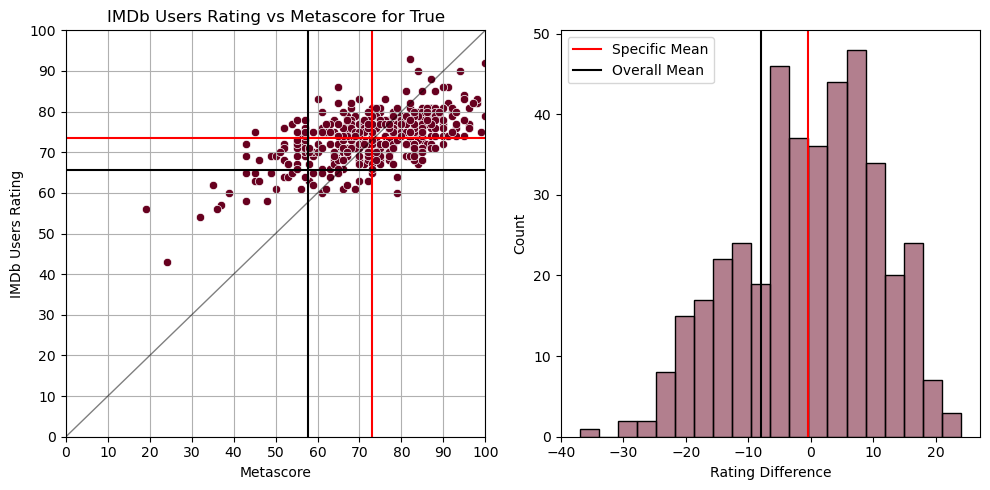

In [115]:
#add a column award_significant at movies_awards 
#the value of the column is True if the award is significant and the correlation is positive and False otherwise
award_correlation_positive = award_pearsonr_results[award_pearsonr_results['correlation'] > 0].index.to_list()
#keep value in the list award_vif_significant and award_correlation_positive
award_significant_correlation_positive = list(set(award_vif_significant) & set(award_correlation_positive))


movies_awards['awards_significant'] = movies_awards.apply(lambda row: row[award_significant_correlation_positive].sum() > 0, axis=1)

utils.plot_specific_scatter(movies_awards, 'awards_significant', True)

When we keep only the movie with award when the correlation between award and rating_difference is significant and positive, the rating_difference is very close to zero. We can assume that professional critics give higher marks when films win awards. But care must be taken, as this result may simply be due to the fact that awards are often given out by professional critics, which can create a significant bias. 